### Auto Encoder Developement

In [1]:
import numpy as np
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import keras_tuner as kt
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import KFold,GridSearchCV,RandomizedSearchCV,train_test_split,StratifiedKFold
from sklearn.metrics import confusion_matrix,accuracy_score,r2_score,roc_auc_score,precision_score,recall_score,f1_score,mean_squared_error
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=True)

In [2]:
col_names = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 'T2', 'T24'
             , 'T30', 'T50','P2', 'P15', 'P30', 'Nf', 'Nc', 'epr', 'Ps30'
             , 'phi', 'NRf', 'NRc', 'BPR','farB', 'htBleed', 'Nf_dmd',
             'PCNfR_dmd','W31', 'W32', 's22', 's23']

Import the training, test, and remaining useful life data and remove all NaN values.

In [3]:
train = pd.read_csv("train.txt", sep=' ', names=col_names)
test = pd.read_csv("test.txt", sep=' ', names=col_names)
RUL = pd.read_csv("RUL.txt", sep=' ', names=['remaining_cycles', 'Nan'])
RUL.head()

,remaining_cycles,Nan
0,112,NaN
1,98,NaN
2,69,NaN
3,82,NaN
4,91,NaN


In [4]:
train.drop(columns=['s22', 's23'], axis=1, inplace=True)
test.drop(columns=['s22', 's23'], axis=1, inplace=True)
RUL.drop(columns=['Nan'], axis=1, inplace=True)

In [5]:
RUL['id'] = RUL.index + 1

RUL.head()

,remaining_cycles,id
0,112,1
1,98,2
2,69,3
3,82,4
4,91,5


The dataset is made up of sensor data for 100 different engines, as can be seen below.

In [6]:
print('Engine IDs:', train.id.unique())

Engine IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100]


## Processing Data

A testing dataset is provided where the engines are not ran until failure, and a complimentary vector is provided for the remaining useful life (RUL) for each engine ID. In order to match the engines in the test set with their corresponding RUL, we must concatenate the two datasets.

Since the engines in the test set are ran until failure, you can calculate the remaining cycles until failure by subtracting the current cycle from the maximum cycle for each engine ID. He does this for the test set as well. Since the remaining useful life for all the test engines are given, as well as their current cycle, the maximum cycles for each engine can be calculated.

In [7]:
train['remaining_cycles'] = train.groupby(['id'])['cycle'].transform(max)-train['cycle']

In [8]:
train

,id,cycle,setting1,setting2,setting3,T2,T24,T30,T50,P2,...,NRf,NRc,BPR,farB,htBleed,Nf_dmd,PCNfR_dmd,W31,W32,remaining_cycles
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735,4
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594,3
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640,1


In [9]:
# Maximum cycles = cycles at test end + remaining useful life

maxCycles = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
maxCycles.columns = ['id', 'max_tested']
maxCycles['max_cycles'] = RUL['remaining_cycles'] + maxCycles['max_tested']
maxCycles.drop(['max_tested'], axis=1, inplace=True)

In [10]:
maxCycles.head()

,id,max_cycles
0,1,143
1,2,147
2,3,195
3,4,188
4,5,189


In [11]:
test = test.merge(maxCycles, on=['id'], how='left')

In [12]:
test['remaining_cycles'] = test['max_cycles'] - test['cycle']
test.drop(['max_cycles'], axis=1, inplace=True)

In [13]:
X = train.drop(['remaining_cycles'], axis=1)

In [14]:
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
gen = MinMaxScaler(feature_range=(0,1))
X = gen.fit_transform(X)
X = pd.DataFrame(X)
X = np.nan_to_num(X)

pt = PowerTransformer()
X = pt.fit_transform(X)
X = np.array(X)

C:\Users\Arash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [15]:
class AutoEncoder(Model):
    def __init__(self, latent_dim, input_dim):
        super(AutoEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.encoder = tf.keras.Sequential([
            # layers.Dense(16*latent_dim, activation = "relu"),
            # layers.Dense(8*latent_dim, activation = "relu"),
            # layers.Dense(4*latent_dim, activation = "relu"),
            # layers.Dense(2*latent_dim, activation = "relu"),
            layers.Dense(latent_dim, activation = "relu"),
        ])
        self.decoder = tf.keras.Sequential([
            layers.Dense(input_dim, activation = "sigmoid"),           
        ])
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
def find_latent_dims(AutoEncoder, latent_dim):
    tf.keras.backend.clear_session()
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
    autoencoder = AutoEncoder(latent_dim)
    autoencoder.compile(optimizer="adam", loss="mean_squared_error")
    history = autoencoder.fit(X, X, epochs=1000, shuffle=True, validation_data=(X, X), verbose=False, callbacks=callback)
    return history

In [17]:
# latent_dim = np.arange(X.shape[1]) + 1

# lossSave = []
# lowestLoss = []
# i = 0
# for dim in latent_dim:
#     history = find_latent_dims(AutoEncoder, dim)
#     lossSave.append(history.history['loss'])
#     lowestLoss.append(lossSave[i][-1])
#     i += 1

In [18]:
# plt.figure(figsize=(20,20))
# plt.scatter(range(len(lowestLoss)), lowestLoss)  
# plt.xlabel("Number of Latent Dimensions")
# plt.ylabel("Mean Squared Error")
# plt.show()

In [19]:
# plt.figure(figsize=(20,20))
# for losses in lossSave:
#     plt.plot(losses)    
# plt.xlabel("Epochs")
# plt.ylabel("Mean Squared Error")
# plt.legend(latent_dim)
# plt.show()


In [20]:
def plot_loss(fit):
    plt.figure(figsize=(16,9))
    plt.plot(fit.history['loss'], label='loss')
    plt.plot(fit.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Remaining Cycles Error')
    plt.legend(loc=0, prop={'size':26})
    plt.grid(True)
    plt.show()

In [21]:
def make_fully_connected_model(autoencoder, loss_type, activation_type):
    autoencoder.encoder.trainable = False
    model = keras.Sequential([autoencoder.encoder,
                              layers.Dense(512, activation=activation_type),
                              layers.BatchNormalization(axis=1),
                              layers.Dense(256, activation=activation_type),
                              layers.BatchNormalization(axis=1),
                              layers.Dense(1024, activation=activation_type),
                              layers.BatchNormalization(axis=1),
                              layers.Dense(64, activation=activation_type),
                              layers.Dropout(0.2),
                              layers.BatchNormalization(axis=1),
                              layers.Dense(16, activation=activation_type),
                              layers.Dense(1, activation="relu")])
    model.compile(loss=loss_type, optimizer=keras.optimizers.Adam(learning_rate=0.001))
    return model

In [22]:
latent_dim = 17
tf.keras.backend.clear_session()
autoencoder = AutoEncoder(latent_dim, X.shape[1])
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.build(X.shape)
autoencoder.summary()

Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (20631, 17)               459       
_________________________________________________________________
sequential_1 (Sequential)    (20631, 26)               468       
Total params: 927
Trainable params: 927
Non-trainable params: 0
_________________________________________________________________


In [23]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
autoencoder.fit(X, X, epochs=1000, shuffle=True, validation_data=(X, X), verbose=False, callbacks=callback)
autoencoder.encoder.trainable = False
autoencoder.encoder.trainable

False

In [24]:
# train_shuffled = train.sample(frac=1)
# X_shuffled = train_shuffled.drop(['remaining_cycles'], axis=1)
# y = train_shuffled.remaining_cycles
y = train.remaining_cycles

In [25]:
dnn = make_fully_connected_model(autoencoder, 'mean_squared_error', 'sigmoid')

In [26]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
history = dnn.fit(X, y, validation_split=(1-(len(train)-(len(train)-16739))/len(train)), verbose=1, epochs=200, callbacks=callback)

Epoch 1/200
524/524 [==============================] - 2s 3ms/step - loss: 14863.0566 - val_loss: 18069.8848
Epoch 2/200
524/524 [==============================] - 2s 3ms/step - loss: 13691.1064 - val_loss: 16683.3105
Epoch 3/200
524/524 [==============================] - 2s 3ms/step - loss: 12383.3916 - val_loss: 15173.0352
Epoch 4/200
524/524 [==============================] - 1s 3ms/step - loss: 11159.5469 - val_loss: 13969.3711
Epoch 5/200
524/524 [==============================] - 1s 3ms/step - loss: 10187.3916 - val_loss: 12945.9229
Epoch 6/200
524/524 [==============================] - 1s 3ms/step - loss: 9312.6953 - val_loss: 11969.6846
Epoch 7/200
524/524 [==============================] - 1s 3ms/step - loss: 8494.1328 - val_loss: 11084.5127
Epoch 8/200
524/524 [==============================] - 1s 3ms/step - loss: 7756.7358 - val_loss: 10238.3213
Epoch 9/200
524/524 [==============================] - 1s 3ms/step - loss: 7078.0854 - val_loss: 9479.0840
Epoch 10/200
524/524 [==

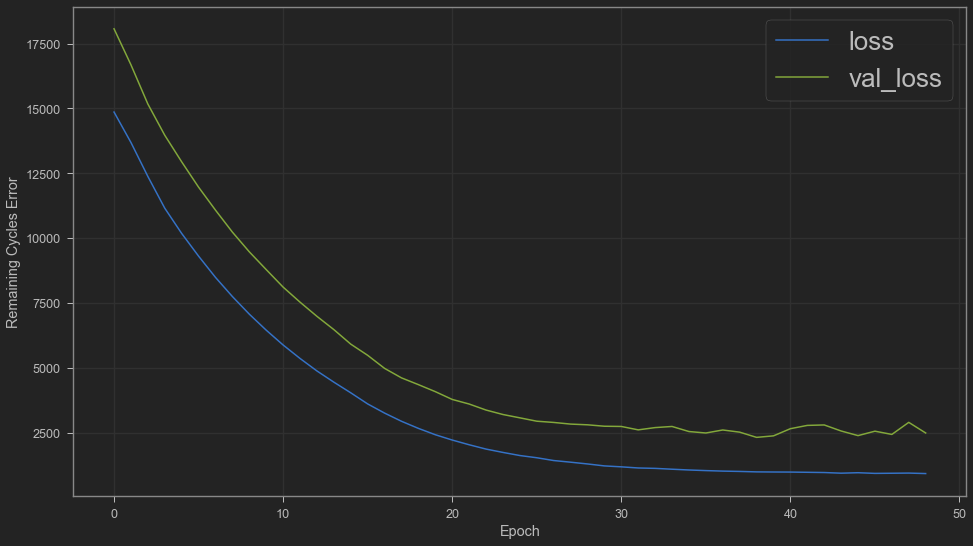

In [27]:
plot_loss(history)

In [35]:
def make_lstm_model(autoencoder, loss_type, activation_type, input):
    autoencoder.encoder.trainable = False
    model = keras.Sequential([autoencoder.encoder,
                              layers.LSTM(128, input_shape=(input[1], input[0]), return_sequences=True),
                              layers.LSTM(64, input_shape=(input[1], input[0]), return_sequences=False),
                              layers.Dense(16, activation=activation_type),
                              layers.TimeDistributed(layers.Dense(1, activation="relu")))
    model.compile(loss=loss_type, optimizer=keras.optimizers.Adam(learning_rate=0.001))
    return model

In [36]:
Xtrain = train.drop(['remaining_cycles'], axis=1)
y = train.remaining_cycles

In [37]:
meanTrain = Xtrain.loc[:, Xtrain.columns != 'cycle'].rolling(10).mean()
meanTrain = meanTrain.join(Xtrain['cycle'])
X = meanTrain[Xtrain.columns]
X.dropna(inplace=True)
y = y[9:]

C:\Users\Arash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [38]:
gen3 = MinMaxScaler(feature_range=(0,1))
X = gen3.fit_transform(X)
X = pd.DataFrame(X)
X = np.nan_to_num(X)

pt = PowerTransformer()
X = pt.fit_transform(X)
X = np.array(X)

C:\Users\Arash\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\preprocessing\_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


In [39]:
AR = 10

def create_dataset(X, AR=AR):
    data = []
    for i in range(len(X)-AR-1):
        data.append(X[i:(i+AR)])
    return np.array(data)

In [40]:
X = create_dataset(X, AR)
y_train = y[AR+1:]

In [46]:
latent_dim = 17
tf.keras.backend.clear_session()
autoencoder = AutoEncoder(latent_dim)
autoencoder.compile(optimizer="adam", loss="mean_squared_error")
autoencoder.build(X.shape)
autoencoder.summary()

Model: "auto_encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (20611, 10, 17)           459       
_________________________________________________________________
sequential_1 (Sequential)    (20611, 10, 26)           468       
Total params: 927
Trainable params: 927
Non-trainable params: 0
_________________________________________________________________


In [47]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10)
autoencoder.fit(X, X, epochs=1000, shuffle=True, validation_data=(X, X), verbose=False, callbacks=callback)
autoencoder.encoder.trainable = False
autoencoder.encoder.trainable

False

In [48]:
lstmModel = make_lstm_model(autoencoder, "mean_squared_error", "sigmoid", [X.shape[2], X.shape[1]])
lstmModel.build([X.shape[2], X.shape[1]])
lstmModel.summary()

ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 26 but received input with shape (26, 10)

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5)
history = lstmModel.fit(X, y, batch_size=512, epochs=500, validation_split=0.15, callbacks=callback, verbose=1)

In [ ]:
plot_loss(history)